In [1]:
# Step 0. Import libraries, custom modules and logging
import kagglehub
# Basics ---------------------------------------------------------------
import logging
import joblib
# Data -----------------------------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning -----------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (mean_squared_error, 
                             mean_absolute_error,
                             r2_score,
                             root_mean_squared_error)
from sklearn.inspection import permutation_importance
from sklearn.svm import SVR 
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
# Logging initialization -----------------------------------------------
logger = logging.getLogger()
logger.setLevel(logging.INFO)

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (OneHotEncoder,
                                   MinMaxScaler,
                                   LabelEncoder,
                                   PowerTransformer, 
                                   StandardScaler
                                  )








/home/codespace/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 1. Create dataframe 
path = kagglehub.dataset_download("shubhambathwal/flight-price-prediction")
df_raw = pd.read_csv('/home/codespace/.cache/kagglehub/datasets/shubhambathwal/flight-price-prediction/versions/2/Clean_Dataset.csv')



## **Data Dictionary**
|Name|Description|Units|Type|
|----|-----------|-----|----|
|airline|The name of the airline company is stored in the airline column. It is a categorical feature having 6 different airlines.|none|category|
|flight|Flight stores information regarding the plane's flight code. It is a categorical feature.|none|category|
|Source City|City from which the flight takes off. It is a categorical feature having 6 unique cities.|none|category|
|Departure Time|This is a derived categorical feature obtained created by grouping time periods into bins. It stores information about the departure time and have 6 unique time labels.|none|category|
|Stops| A categorical feature with 3 distinct values that stores the number of stops between the source and destination cities.|none|category|
|Arrival Time| This is a derived categorical feature created by grouping time intervals into bins. It has six distinct time labels and keeps information about the arrival time.|none|category|
|Destination City| City where the flight will land. It is a categorical feature having 6 unique cities.|none|category|
|Class| A categorical feature that contains information on seat class; it has two distinct values: Business and Economy.|none|category|
|Duration| A continuous feature that displays the overall amount of time it takes to travel between cities in hours.|none|float|
|Price| Target variable stores information of the ticket price.|none|int|

In [3]:
# 1.1 Read from source and get basic info
df_raw.info(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


In [4]:
# 1.2 Get a sample
df_raw.sample(5)

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
49322,49322,Indigo,6E-168,Mumbai,Morning,zero,Afternoon,Delhi,Economy,2.25,33,2738
51361,51361,GO_FIRST,G8-331,Mumbai,Morning,one,Night,Delhi,Economy,8.83,42,10409
281848,281848,Vistara,UK-874,Hyderabad,Morning,one,Evening,Bangalore,Business,9.25,30,38099
97572,97572,AirAsia,I5-941,Bangalore,Early_Morning,zero,Early_Morning,Mumbai,Economy,1.67,22,2201
59628,59628,Air_India,AI-864,Mumbai,Early_Morning,one,Evening,Bangalore,Economy,9.25,39,6082


In [5]:
# Step 2. Prepare the dataset for analysis
df_interim = (
    df_raw
    .copy()
    .set_axis(
        df_raw.columns.str.replace(' ', '_') # reemplazar espacio por _
        .str.replace(r'\W','',regex=True) # reemplazar caracteres no alfabéticos por nada
        .str.lower() # el resultado lo pasamos a minúsculas
        .str.slice(0,40), axis=1, # slice sirve para cortar el texto a un máximo de 40 caracteres
    )
    .rename(columns={'price':'target'})
    #.astype({'target': np.float16})
    .iloc[:,1:]
    .drop("flight", axis = 1)
    .astype({"airline": "category", "source_city": "category", "departure_time": "category", "stops": "category", "arrival_time": "category", "destination_city": "category", "class": "category"})
   .assign(target_log=lambda df: df["target"].apply(
        lambda x: np.log(x + 1) if x == 0 else np.log(x)
    ))
    .assign(duration_log=lambda df: df["duration"].apply(
        lambda x: np.log(x + 1) if x == 0 else np.log(x)
    )
    
    )
        
) 
df_interim.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   airline           300153 non-null  category
 1   source_city       300153 non-null  category
 2   departure_time    300153 non-null  category
 3   stops             300153 non-null  category
 4   arrival_time      300153 non-null  category
 5   destination_city  300153 non-null  category
 6   class             300153 non-null  category
 7   duration          300153 non-null  float64 
 8   days_left         300153 non-null  int64   
 9   target            300153 non-null  int64   
 10  target_log        300153 non-null  float64 
 11  duration_log      300153 non-null  float64 
dtypes: category(7), float64(3), int64(2)
memory usage: 13.5 MB


In [6]:
df_interim["departure_time"].value_counts()

departure_time
Morning          71146
Early_Morning    66790
Evening          65102
Night            48015
Afternoon        47794
Late_Night        1306
Name: count, dtype: int64

In [7]:
df_interim_transformed = df_interim.copy()
df_interim_transformed= df_interim_transformed.drop(["target", "duration"], axis=1)
df_interim_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   airline           300153 non-null  category
 1   source_city       300153 non-null  category
 2   departure_time    300153 non-null  category
 3   stops             300153 non-null  category
 4   arrival_time      300153 non-null  category
 5   destination_city  300153 non-null  category
 6   class             300153 non-null  category
 7   days_left         300153 non-null  int64   
 8   target_log        300153 non-null  float64 
 9   duration_log      300153 non-null  float64 
dtypes: category(7), float64(2), int64(1)
memory usage: 8.9 MB


In [8]:
# 2.2 Create the final dataset with the target in front, show result
df = (
    df_interim_transformed
    .copy()
    .reindex(
        columns=(
            ['target_log'] + 
            [c for c in df_interim_transformed.columns.to_list() if c not in ['target_log']]
        )
    )
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   target_log        300153 non-null  float64 
 1   airline           300153 non-null  category
 2   source_city       300153 non-null  category
 3   departure_time    300153 non-null  category
 4   stops             300153 non-null  category
 5   arrival_time      300153 non-null  category
 6   destination_city  300153 non-null  category
 7   class             300153 non-null  category
 8   days_left         300153 non-null  int64   
 9   duration_log      300153 non-null  float64 
dtypes: category(7), float64(2), int64(1)
memory usage: 8.9 MB


In [9]:
df.sample(10)

,target_log,airline,source_city,departure_time,stops,arrival_time,destination_city,class,days_left,duration_log
150246,8.777864,Indigo,Kolkata,Evening,one,Night,Chennai,Economy,25,1.673351
2159,8.691986,Indigo,Delhi,Evening,one,Night,Mumbai,Economy,13,1.673351
262169,10.891969,Air_India,Kolkata,Afternoon,one,Morning,Delhi,Business,17,3.056357
210393,10.881137,Vistara,Delhi,Morning,one,Night,Mumbai,Business,35,2.621039
140961,8.811950,GO_FIRST,Kolkata,Early_Morning,one,Afternoon,Bangalore,Economy,39,2.079442
126033,8.293800,Indigo,Kolkata,Early_Morning,zero,Early_Morning,Delhi,Economy,41,0.916291
202302,8.313607,Indigo,Chennai,Afternoon,one,Night,Kolkata,Economy,46,2.178155
17501,8.861775,SpiceJet,Delhi,Morning,one,Morning,Bangalore,Economy,37,3.044522
32330,7.648740,Air_India,Delhi,Morning,zero,Morning,Hyderabad,Economy,29,0.774727
49928,7.868637,SpiceJet,Mumbai,Evening,zero,Night,Delhi,Economy,36,0.883768


In [10]:
# Step 3. Perform EDA
# 3.1 Split the dataset
df_train, df_test = train_test_split(df, 
                                     random_state=2024, 
                                     test_size=0.2)
df_train = df_train.reset_index(drop=True).sort_values(by='target_log')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240122 entries, 193521 to 143788
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   target_log        240122 non-null  float64 
 1   airline           240122 non-null  category
 2   source_city       240122 non-null  category
 3   departure_time    240122 non-null  category
 4   stops             240122 non-null  category
 5   arrival_time      240122 non-null  category
 6   destination_city  240122 non-null  category
 7   class             240122 non-null  category
 8   days_left         240122 non-null  int64   
 9   duration_log      240122 non-null  float64 
dtypes: category(7), float64(2), int64(1)
memory usage: 8.9 MB


In [11]:
display(df_train.describe(include='category').T)
display(df_train.describe().T)

,count,unique,top,freq
airline,240122,6,Vistara,102169
source_city,240122,6,Delhi,49094
departure_time,240122,6,Morning,57052
stops,240122,3,one,200783
arrival_time,240122,6,Night,73214
destination_city,240122,6,Mumbai,47253
class,240122,2,Economy,165367


,count,mean,std,min,25%,50%,75%,max
target_log,240122.0,9.330416,1.112603,7.007601,8.472823,8.912608,10.657753,11.720517
days_left,240122.0,26.001533,13.558442,1.000000,15.000000,26.000000,38.000000,49.000000
duration_log,240122.0,2.283560,0.735436,-0.186330,1.921325,2.420368,2.783158,3.908617


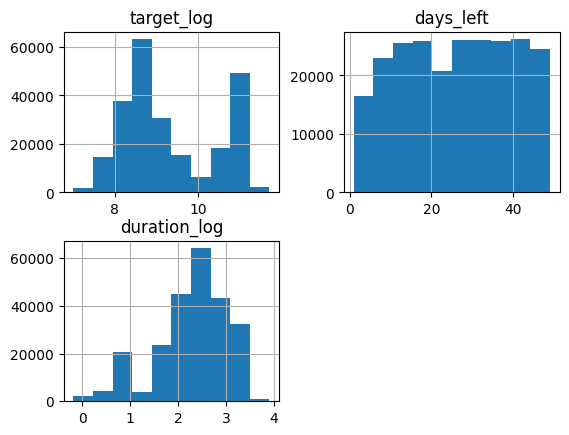

In [12]:
# Análisis univariado variables numéricas
df_train.hist()
plt.show()

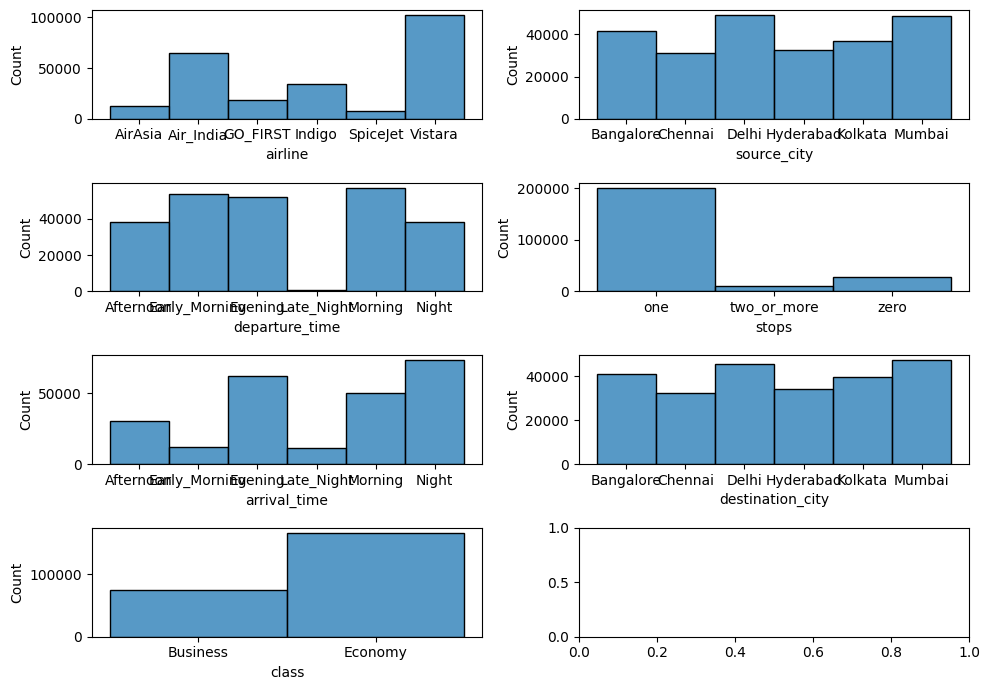

In [13]:
# Análisis univariado variables categóricas
fig, axis = plt.subplots(4, 2, figsize = (10, 7))
sns.histplot(ax = axis[0, 0], data = df_train, x = "airline")
sns.histplot(ax = axis[0, 1], data = df_train, x = "source_city")
sns.histplot(ax = axis[1, 0], data = df_train, x = "departure_time")
sns.histplot(ax = axis[1, 1], data = df_train, x = "stops")
sns.histplot(ax = axis[2, 0], data = df_train, x = "arrival_time")
sns.histplot(ax = axis[2, 1], data = df_train, x = "destination_city")
sns.histplot(ax = axis[3, 0], data = df_train, x = "class")
plt.tight_layout()
plt.show()

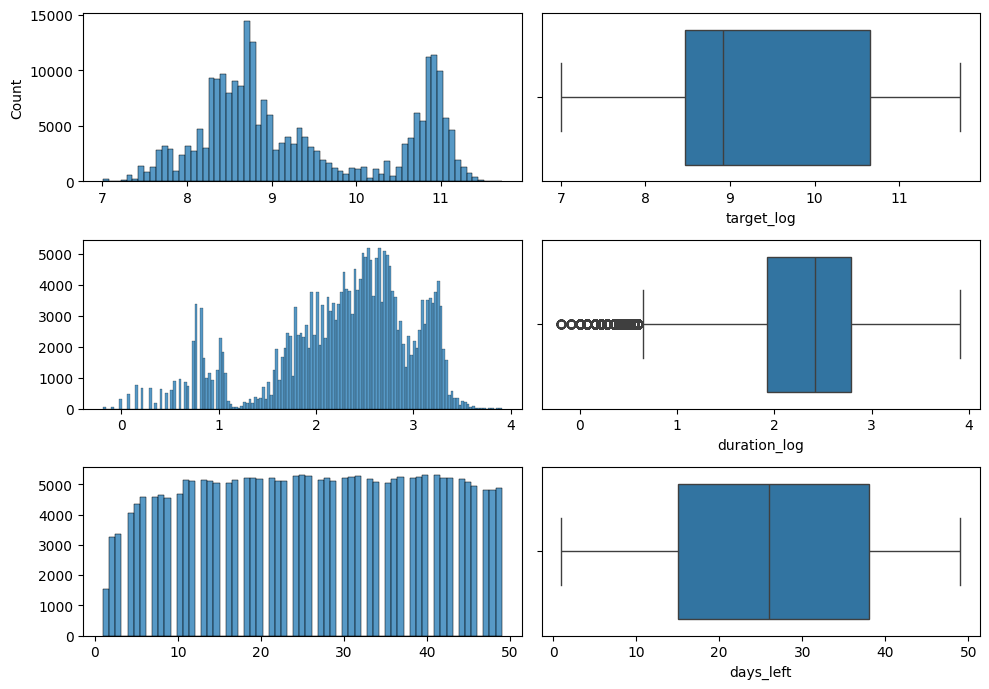

In [14]:
# Análisis variado variables numericas
fig, axis = plt.subplots(3, 2, figsize = (10, 7))
sns.histplot(ax = axis[0, 0], data = df_train, x= "target_log").set(xlabel = None)
sns.boxplot(ax = axis[0, 1], data = df_train, x = "target_log")
sns.histplot(ax = axis[1, 0], data = df_train, x = "duration_log").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[1, 1], data = df_train, x = "duration_log")
sns.histplot(ax = axis[2, 0], data = df_train, x = "days_left").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[2, 1], data = df_train, x = "days_left")
# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

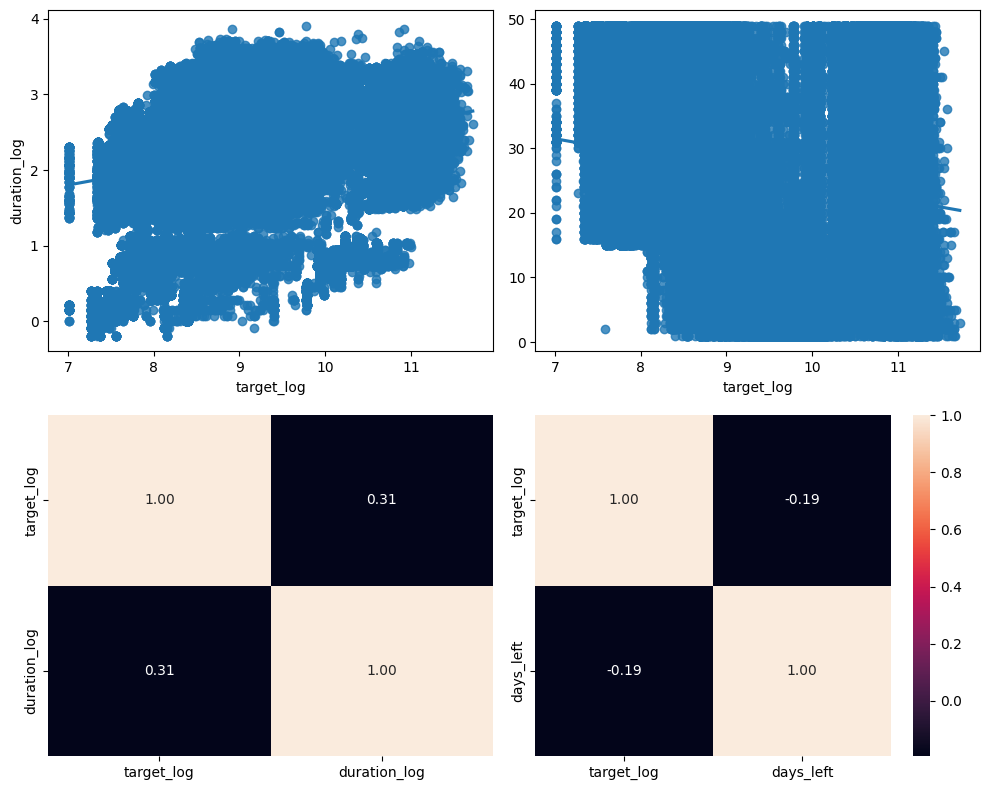

In [15]:
# Análisis bivariado variables categóricas
# Create a multiple scatter diagram
fig, axis = plt.subplots(2, 2, figsize=(10, 8))

# Gráficos de regresión y heatmaps
sns.regplot(ax=axis[0, 0], data=df_train, x="target_log", y="duration_log")
sns.heatmap(df_train[["target_log", "duration_log"]].corr(), annot=True, fmt=".2f", ax=axis[1, 0], cbar=False)
sns.regplot(ax=axis[0, 1], data=df_train, x="target_log", y="days_left").set(ylabel=None)
sns.heatmap(df_train[["target_log", "days_left"]].corr(), annot=True, fmt=".2f", ax=axis[1, 1])

# Ajustar diseño
plt.tight_layout()
plt.show()

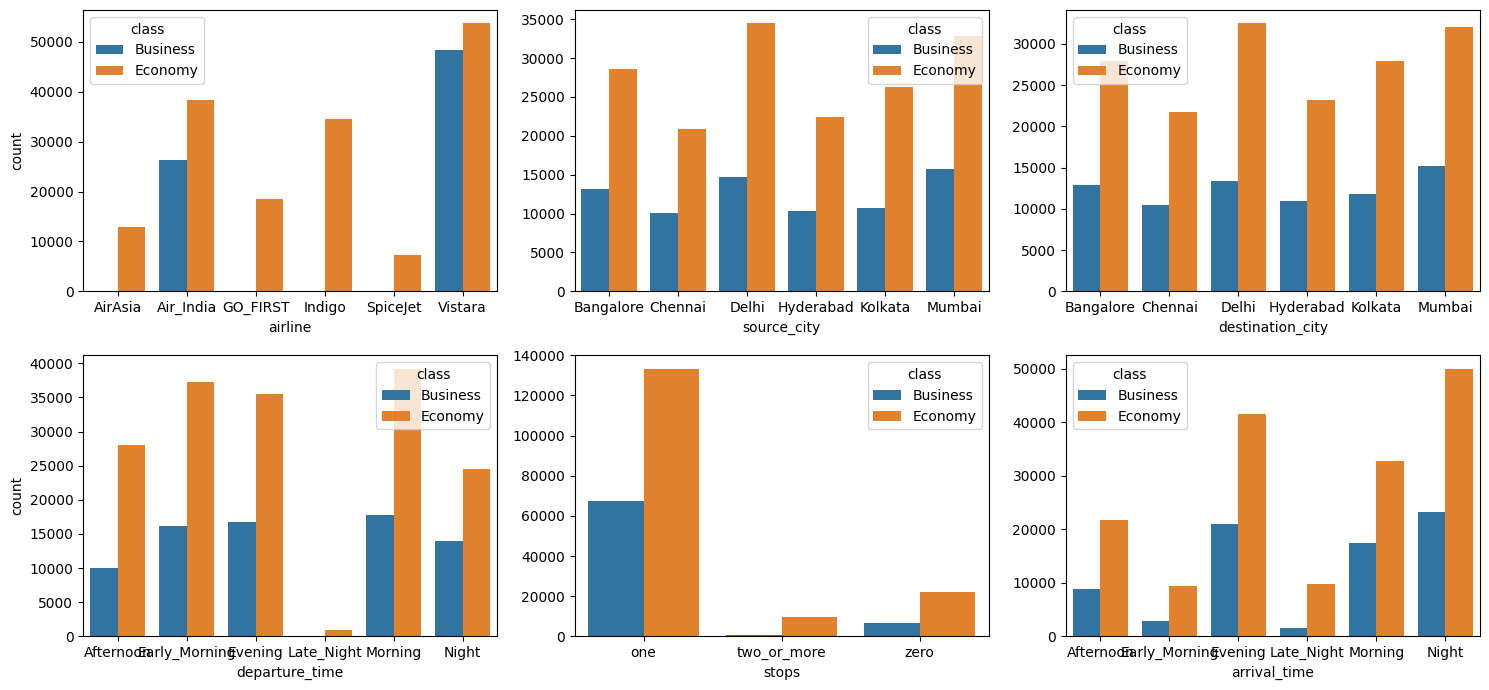

In [16]:
#Análisis bivariado variables categóricas

fig, axis = plt.subplots(2, 3, figsize = (15, 7))

sns.countplot(ax = axis[0, 0], data = df_train, x = "airline", hue = "class")
sns.countplot(ax = axis[0, 1], data = df_train, x = "source_city", hue = "class").set(ylabel = None)
sns.countplot(ax = axis[0, 2], data = df_train, x = "destination_city", hue = "class").set(ylabel = None)
sns.countplot(ax = axis[1, 0], data = df_train, x = "departure_time", hue = "class")
sns.countplot(ax = axis[1, 1], data = df_train, x = "stops", hue = "class").set(ylabel = None)
sns.countplot(ax = axis[1, 2], data = df_train, x = "arrival_time", hue = "class").set(ylabel = None)

plt.tight_layout()
#fig.delaxes(axis[1, 2])

plt.show()

In [32]:
label_encoder = LabelEncoder()
for col in df:
    df[col] = label_encoder.fit_transform(df[col])

Falta el heatmap 


In [18]:
sc = StandardScaler()

In [19]:
ds_x = df.drop('target_log',axis=1)
y = df['target_log']

In [20]:
df_t = sc.fit_transform(ds_x)
x = pd.DataFrame(df_t,columns=ds_x.columns)

In [21]:
x

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,days_left,duration_log
0,0.488270,-0.329721,-0.237897,2.577006,1.105790,1.382425,0.672576,-1.843875,-1.405317
1,0.488270,-0.329721,-0.807934,2.577006,0.531627,1.382425,0.672576,-1.843875,-1.382385
2,-1.693633,-0.329721,-0.807934,2.577006,-1.190865,1.382425,0.672576,-1.843875,-1.405317
3,1.033746,-0.329721,0.902176,2.577006,-1.765028,1.382425,0.672576,-1.843875,-1.393851
4,1.033746,-0.329721,0.902176,2.577006,0.531627,1.382425,0.672576,-1.843875,-1.382385
...,...,...,...,...,...,...,...,...,...
300148,1.033746,-0.900576,0.902176,-0.426792,-0.616701,0.235992,-1.486822,1.695692,-0.293077
300149,1.033746,-0.900576,-1.377971,-0.426792,1.105790,0.235992,-1.486822,1.695692,-0.247212
300150,1.033746,-0.900576,-0.807934,-0.426792,1.105790,0.235992,-1.486822,1.695692,0.234377
300151,1.033746,-0.900576,-0.807934,-0.426792,-0.616701,0.235992,-1.486822,1.695692,-0.304544


In [ ]:
dt = DecisionTreeRegressor()
knn = KNeighborsRegressor()
lr = LinearRegression()

In [36]:
X_train, X_test, y_train,y_test = train_test_split(x,y, test_size=0.2, random_state=2024)
for i in [dt]:
    i.fit(X_train, y_train)
    pred = i.predict(X_test)
    test_score = r2_score(y_test, pred)
    train_score = r2_score(y_train, i.predict(X_train))
    if abs(train_score - test_score) <= 0.1:
        print(i)
        print(f'R2 score is: {r2_score(y_test, pred)}')
        print(f'R2 for train data is:{r2_score(y_train,i.predict(X_train))}')
        print(f'mean absolute error is:{mean_absolute_error(y_test,pred)}')
        print(f'mean squared error is:{mean_squared_error(y_test,pred)}')
        print(f'root mean squared is:{root_mean_squared_error(y_test,pred)}')

DecisionTreeRegressor()
R2 score is: 0.9647388525665965
R2 for train data is:0.9995335167531002
mean absolute error is:283.8235828155453
mean squared error is:595552.040187107
root mean squared is:771.7201825707988


In [28]:
X_train, X_test, y_train,y_test = train_test_split(x,y, test_size=0.2, random_state=2024)
for i in [knn]:
    i.fit(X_train, y_train)
    pred = i.predict(X_test)
    test_score = r2_score(y_test, pred)
    train_score = r2_score(y_train, i.predict(X_train))
    if abs(train_score - test_score) <= 0.1:
        print(i)
        print(f'R2 score is: {r2_score(y_test, pred)}')
        print(f'R2 for train data is:{r2_score(y_train,i.predict(X_train))}')
        print(f'mean absolute error is:{mean_absolute_error(y_test,pred)}')
        print(f'mean squared error is:{mean_squared_error(y_test,pred)}')
        print(f'root mean squared is:{root_mean_squared_error(y_test,pred)}') 

KNeighborsRegressor()
R2 score is: 0.96557060495731
R2 for train data is:0.9781349467448885
mean absolute error is:407.51726274758045
mean squared error is:581503.948469291
root mean squared is:762.5640618789289


In [27]:
X_train, X_test, y_train,y_test = train_test_split(x,y, test_size=0.2, random_state=2024)
for i in [lr]:
    i.fit(X_train, y_train)
    pred = i.predict(X_test)
    test_score = r2_score(y_test, pred)
    train_score = r2_score(y_train, i.predict(X_train))
    if abs(train_score - test_score) <= 0.1:
        print(i)
        print(f'R2 score is: {r2_score(y_test, pred)}')
        print(f'R2 for train data is:{r2_score(y_train,i.predict(X_train))}')
        print(f'mean absolute error is:{mean_absolute_error(y_test,pred)}')
        print(f'mean squared error is:{mean_squared_error(y_test,pred)}')
        print(f'root mean squared is:{root_mean_squared_error(y_test,pred)}')

LinearRegression()
R2 score is: 0.8648499882423014
R2 for train data is:0.8633808552709912
mean absolute error is:1175.8480011986285
mean squared error is:2282650.199787895
root mean squared is:1510.8442010306342


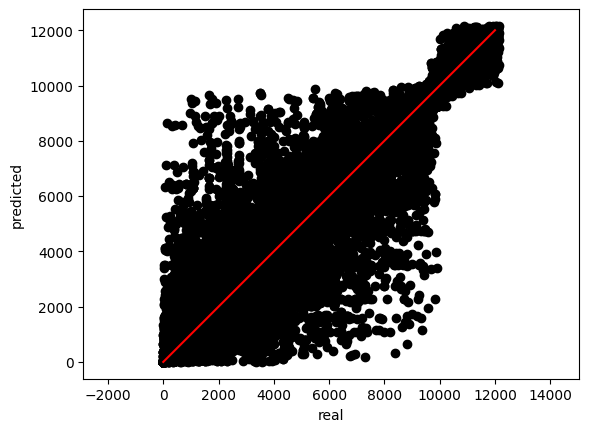

In [56]:
plt.scatter(x= y_test, y= pred, c= 'k')
plt.plot([0,12000],[0,12000], c= 'r')
plt.axis('equal')
plt.xlabel('real')
plt.ylabel('predicted')
plt.show()